# Эксперименты с алгоритмами

Разделим датасет на train/test

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
X, y = fetch_openml("mnist_784", return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)

## C-PCA

In [45]:
from scipy.special import lambertw
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
class cPCA:
    def __init__(self):
        self.dimension_ = -1
        self.shape = 0

    def mininmum_set_cover(self, data, n_neighbors): # O(n^2*log(n))
        n = data.shape[0]
        temp = NearestNeighbors(n_neighbors=n_neighbors+1)
        temp.fit(data)
        temp = temp.kneighbors_graph(data) # CSR matrix
        q = np.array(temp.sum(axis=0).astype('int32')).squeeze()
        temp = temp.indices.reshape([n, n_neighbors + 1]) # Matrix with indices of neighbors
        taken = np.full(n, True)
        for i in range(n):
            if (q[temp[i]] > 1).all():
                q[temp[i]] -= 1
                taken[i] = False
        return temp[taken]

        

    def fit(self, data, n_neighbors = 20, alpha = 10, beta = 0.95, P = 0.95, noise = False): # O(n*k + n^2*log(n))
        data = np.array(data)
        n = data.shape[0]
        self.D = distance.cdist(data, data, 'euclidean')
        
        F = self.mininmum_set_cover(data, n_neighbors)
        dims = []

        for sub in range(F.shape[0]):
            cur_data = np.array(data[F[sub]])
            covariance_matrix = np.cov(cur_data.T)
            eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
            eigen_values = list(reversed(sorted(eigen_values)))
            if noise:
                sum_var = sum(eigen_values)
                cur_sum = 0
                r = 0
                for i in range(data.shape[1] - 1):
                    cur_sum += eigen_values[i]
                    if cur_sum / sum_var <= P and (cur_sum + eigen_values[i + 1]) / sum_var >= P:
                        r = i + 1
                        break
                if r == 0:
                    raise Exception("don't find noise") 
                sigma = 0; cnt = 0
                for i in range(max(r, data.shape[1] - 10), data.shape[1]):
                    cnt += 1 
                    sigma += eigen_values[i]
                sigma /= cnt
                eigen_values -= sigma
            # criterions
            sum_var = sum(eigen_values)
            cur_sum = 0
            flag = False
            for d in range(len(eigen_values) - 1):
                cur_sum += eigen_values[d]
                if (eigen_values[d] / eigen_values[d + 1] > alpha) or (cur_sum / sum_var > beta): 
                    flag = True
                    dims.append(d + 1)
                    break
            if not flag:
                dims.append(len(eigen_values))
        self.dimension_ = np.mean(dims)

In [55]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
k_list = np.arange(20, 201, 20)
k_train = []
k_test = []
k_train_trans = []
k_test_trans = []
for k in k_list:
    model = cPCA()
    model.fit(X_train, n_neighbors=k)
    temp = PCA(n_components=int(np.round(model.dimension_)))
    X_train_trans = temp.fit_transform(X_train)
    X_test_trans = temp.transform(X_test)
    model = SVC()
    model.fit(X_train, y_train)
    train_ans = model.predict(X_train)
    test_ans = model.predict(X_test)
    k_train.append(accuracy_score(y_train, train_ans))
    k_test.append(accuracy_score(y_test, test_ans))
    model.fit(X_train_trans, y_train)
    train_ans = model.predict(X_train_trans)
    test_ans = model.predict(X_test_trans)
    k_train_trans.append(accuracy_score(y_train, train_ans))
    k_test_trans.append(accuracy_score(y_test, test_ans))
    print(f"k = {k} finished")
    




k = 20 finished
k = 40 finished
k = 60 finished
k = 80 finished
k = 100 finished
k = 120 finished
k = 140 finished
k = 160 finished
k = 180 finished
k = 200 finished


In [60]:
dims = []
for k in k_list:
    model = cPCA()
    model.fit(X_train, n_neighbors=k)
    dims.append(model.dimension_
    )
    print(f"k = {k} finished")
    

k = 20 finished
k = 40 finished
k = 60 finished
k = 80 finished
k = 100 finished
k = 120 finished
k = 140 finished
k = 160 finished
k = 180 finished
k = 200 finished


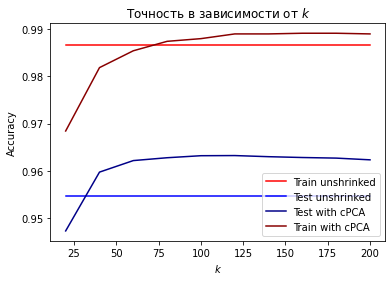

In [59]:
import matplotlib.pyplot as plt
plt.title("Точность в зависимости от $k$")
plt.xlabel("$k$")
plt.ylabel("Accuracy")
plt.plot(k_list, k_train, color='#FF0000', label="Train unshrinked")
plt.plot(k_list, k_test, color='#0000FF', label="Test unshrinked")
plt.plot(k_list, k_test_trans, color='#000088', label="Test with cPCA")
plt.plot(k_list, k_train_trans, color='#880000', label="Train with cPCA")
plt.legend()
plt.show()

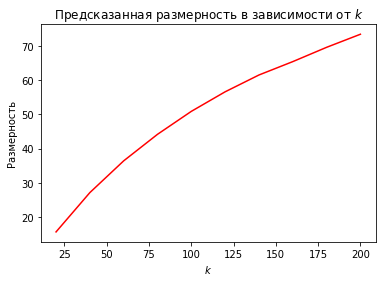

In [61]:
plt.title("Предсказанная размерность в зависимости от $k$")
plt.xlabel("$k$")
plt.ylabel("Размерность")
plt.plot(k_list, dims, color='#FF0000', label="Train unshrinked")
plt.show()

## FisherS

In [56]:
class FisherS:
    def __init__(self):
        self.dimension_ = -1

    def fit(self, X, alpha = 0.8, C = 10):
        # centering
        X_mean = np.mean(X, axis=0)
        X -= X_mean
        # apply PCA
        pca = PCA()
        u = pca.fit_transform(X)
        v = pca.components_.T
        s = pca.explained_variance_
        sc = s / s[0]
        ind = np.where(sc > 1 / C)[0]
        X = X @ v[:,ind]
        # whitening
        X = u[:, ind]
        st = np.std(X, axis=0, ddof=1)
        #project on sphere 
        st = np.sqrt(np.sum(X**2, axis=1))
        st = np.array([st]).T
        X = X/st
        # Compute the Gram matrix
        xy = X @ X.T
        dxy = np.diag(xy)
        sm = (xy / dxy).T
        sm = sm - np.diag(np.diag(sm))
        sm = sm > alpha
        py = sum(sm.T)
        py = py / len(py)
        separ_fraction = sum(py == 0) / len(py)
        #
        py_mean = np.mean(py)
        n_alpha = np.nan
        if py_mean != 0:
            p = py_mean
            a2 = alpha ** 2
            w = np.log(1 - a2)
            n_alpha = lambertw(-(w/(2*np.pi*p*p*a2*(1-a2))))/(-w)
        if n_alpha == np.inf:
            n_alpha = float('nan')
        self.dimension_ = np.real(n_alpha)

In [62]:
k_train_trans = []
k_test_trans = []
for k in k_list:
    model = FisherS()
    model.fit(X_train, C=k)
    dims.append(model.dimension_)
    temp = PCA(n_components=int(np.round(model.dimension_)))
    X_train_trans = temp.fit_transform(X_train)
    X_test_trans = temp.transform(X_test)
    model = SVC()
    model.fit(X_train, y_train)
    train_ans = model.predict(X_train)
    test_ans = model.predict(X_test)
    k_train.append(accuracy_score(y_train, train_ans))
    k_test.append(accuracy_score(y_test, test_ans))
    model.fit(X_train_trans, y_train)
    train_ans = model.predict(X_train_trans)
    test_ans = model.predict(X_test_trans)
    k_train_trans.append(accuracy_score(y_train, train_ans))
    k_test_trans.append(accuracy_score(y_test, test_ans))
    print(f"k = {k} finished")

k = 20 finished
k = 40 finished
k = 60 finished
k = 80 finished
k = 100 finished
k = 120 finished
k = 140 finished
k = 160 finished
k = 180 finished
k = 200 finished


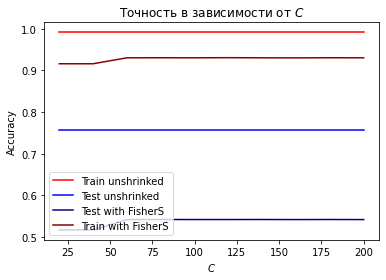

In [65]:
import matplotlib.pyplot as plt
plt.title("Точность в зависимости от $C$")
plt.xlabel("$C$")
plt.ylabel("Accuracy")
plt.plot(k_list, k_train[-10:], color='#FF0000', label="Train unshrinked")
plt.plot(k_list, k_test[-10:], color='#0000FF', label="Test unshrinked")
plt.plot(k_list, k_test_trans[-10:], color='#000088', label="Test with FisherS")
plt.plot(k_list, k_train_trans[-10:], color='#880000', label="Train with FisherS")
plt.legend()
plt.show()

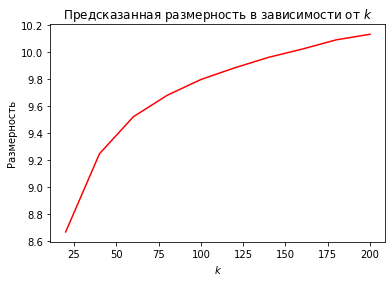

In [66]:
plt.title("Предсказанная размерность в зависимости от $k$")
plt.xlabel("$k$")
plt.ylabel("Размерность")
plt.plot(k_list, dims[-10:], color='#FF0000', label="Train unshrinked")
plt.show()